In [32]:
"""
This example loads the tetra3 default database and solves for every image in the tetra3/test_data directory.

Note: Requires PIL (pip install Pillow)
"""

import sys
sys.path.append('..')
from tetra3 import Tetra3
from PIL import Image
from pathlib import Path
import numpy as np

from astropy.time import Time
from astropy import units
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

from matplotlib import pyplot as plt


In [25]:
def norm(x: np.ndarray):
    """Calcualte the norm of a vector. """
    
    return np.sqrt(np.sum(x**2))

In [5]:
# Create instance and load default_database (built with max_fov=12 and the rest as default)
t3 = Tetra3('default_database')

# Path where images are
path = Path('../test_data/')
for impath in path.glob('*.tiff'):
    print('Solving for image at: ' + str(impath))
    with Image.open(str(impath)) as img:
        solved = t3.solve_from_image(img)  # Adding e.g. fov_estimate=11.4, fov_max_error=.1 improves performance
    #print('Solution: ' + str(solved))
    break

2022-08-08 13:33:34,153:tetra3.Tetra3-INFO: Loading database from: /Users/fischchr/Documents/code/python/tetra3/examples/../default_database.npz


Solving for image at: ../test_data/2019-07-29T204726_Alt60_Azi45_Try1.tiff


In [11]:
def get_ra_dec_from_vector(v: np.ndarray) -> tuple[float]:
    """Get the right ascention and declination from a vector v on the celestial sphere. """
    
    # Make sure v is normalized
    v = v / norm(v)
    
    dec = np.arcsin(v[2])
    ra = np.arccos(v[0] / np.cos(dec))
    
    return (ra, dec)

def get_vector_from_ra_dec(ra: float, dec: float) -> np.ndarray:
    """Get a unit vector on the celestial sphere from (ra, dec) values. """
    
    return np.array([
        np.cos(ra) * np.cos(dec),
        np.sin(ra) * np.cos(dec),
        np.sin(dec)
    ])

test_radec = (10 * np.pi / 180, 35 * np.pi / 180)
res = get_ra_dec_from_vector(get_vector_from_ra_dec(*test_radec)) 
assert all([abs(x - y) < 1e-12 for x, y in zip(test_radec, res)])

In [53]:
# Define the position of the observer
obsloc = EarthLocation(lat=40*units.degree, lon=8*units.degree, height=300*units.m)

# Define the time of the observation
obstime = Time.now()

# Define the ENU frame at the position of the observer
alt_az_frame = AltAz(obstime=obstime, location=obsloc)

In [50]:
# Iterate over all matched stars
for i in range(solved['Matches']):
    # Get the image vector from the image
    v_image = solved['matched_vectors'][i]
    # Get the corresponding database vector
    v_db = solved['matched_database_vectors'][i]
    # Get the rotation matrix that transforms v_db to v_image
    R = solved['rotation_matrix']
    
    # Calculate the residual error |R.v_db - v_image|
    res = norm(R @ v_db - v_image)
    
    radec_image = get_ra_dec_from_vector(v_image)
    radec_db = get_ra_dec_from_vector(v_db)
    
    # Get the coordinates of the star in the sky
    coos_db = SkyCoord(ra=radec_db[0] * units.radian, dec=radec_db[1] * units.radian, frame='icrs')
    
    # Transform the coordinates of the star to the ENU frame of the observer
    aa_db = coos_db.transform_to(alt_az_frame)
    
    # Get the vector of the star in the ENU frame of the observer
    v_db = np.array(aa_db.cartesian.xyz)
    
    print(v_db)


[ 0.76696308 -0.43888509  0.46813193]
[ 0.72156933 -0.4652634   0.51270623]
[ 0.70700236 -0.45140794  0.54440659]
[ 0.77453244 -0.40425445  0.48649547]
[ 0.724178   -0.35891819  0.58884969]
[ 0.75346666 -0.49601458  0.43157563]
[ 0.72933157 -0.4956521   0.47159777]
[ 0.7879704  -0.37024274  0.49195829]
[ 0.70169488 -0.43714198  0.56261105]
[ 0.77593398 -0.46150027  0.43005113]
[ 0.73959185 -0.39102109  0.54781969]
[ 0.7487576  -0.48107635  0.45599079]
[ 0.70817226 -0.48701589  0.51118252]


In [ ]:
units.radian

In [37]:

# Get the coordinate frame for the observation time



array([ 0.53097001, -0.62811743, -0.56880519])

In [6]:
from tetra3 import get_centroids_from_image

In [28]:
centroids = get_centroids_from_image(img)

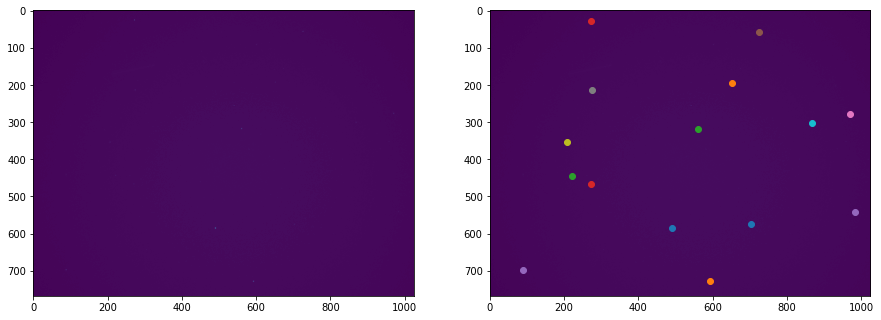

In [29]:
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(img)

plt.subplot(1,2,2)
plt.imshow(img)
for point in centroids:
    plt.plot(point[1], point[0], 'o')

In [21]:
impath

PosixPath('../test_data/2019-07-29T204726_Alt60_Azi-135_Try1.tiff')